In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display_html
from sklearn.decomposition import PCA

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/NBA/NBA_DATA.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop(['Season', 'Match Number', 'Round Number', 'Week', 'Date',
              'Location', 'AB_HOME', 'GOW_HOME', 'AB_AWAY', 'GOW_AWAY', 'Result'], axis=1)
df['OffRtg_Diff'] = df.apply(lambda x: x['OffRtg_HOME'] - x['OffRtg_AWAY'], axis=1)
df['OffRtg_Diff_HOME'] = df.apply(lambda x: x['OffRtg_HOME'] - x['DefRtg_AWAY'], axis=1)
df['OffRtg_Diff_AWAY'] = df.apply(lambda x: x['OffRtg_AWAY'] - x['DefRtg_HOME'], axis=1)
df['DefRtg_Diff'] = df.apply(lambda x: x['DefRtg_HOME'] - x['DefRtg_AWAY'], axis=1)
df['NetRtg_Diff'] = df.apply(lambda x: x['NetRtg_HOME'] - x['NetRtg_AWAY'], axis=1)
df['PaceRtg_Diff'] = df.apply(lambda x: x['Pace_HOME'] - x['Pace_AWAY'], axis=1)
df.shape

(5726, 18)

In [4]:
encoder = LabelEncoder()
df[['Home Team', 'Away Team']] = df[['Home Team', 'Away Team']].apply(encoder.fit_transform)
dfName = {index : label for index, label in enumerate(encoder.classes_)}

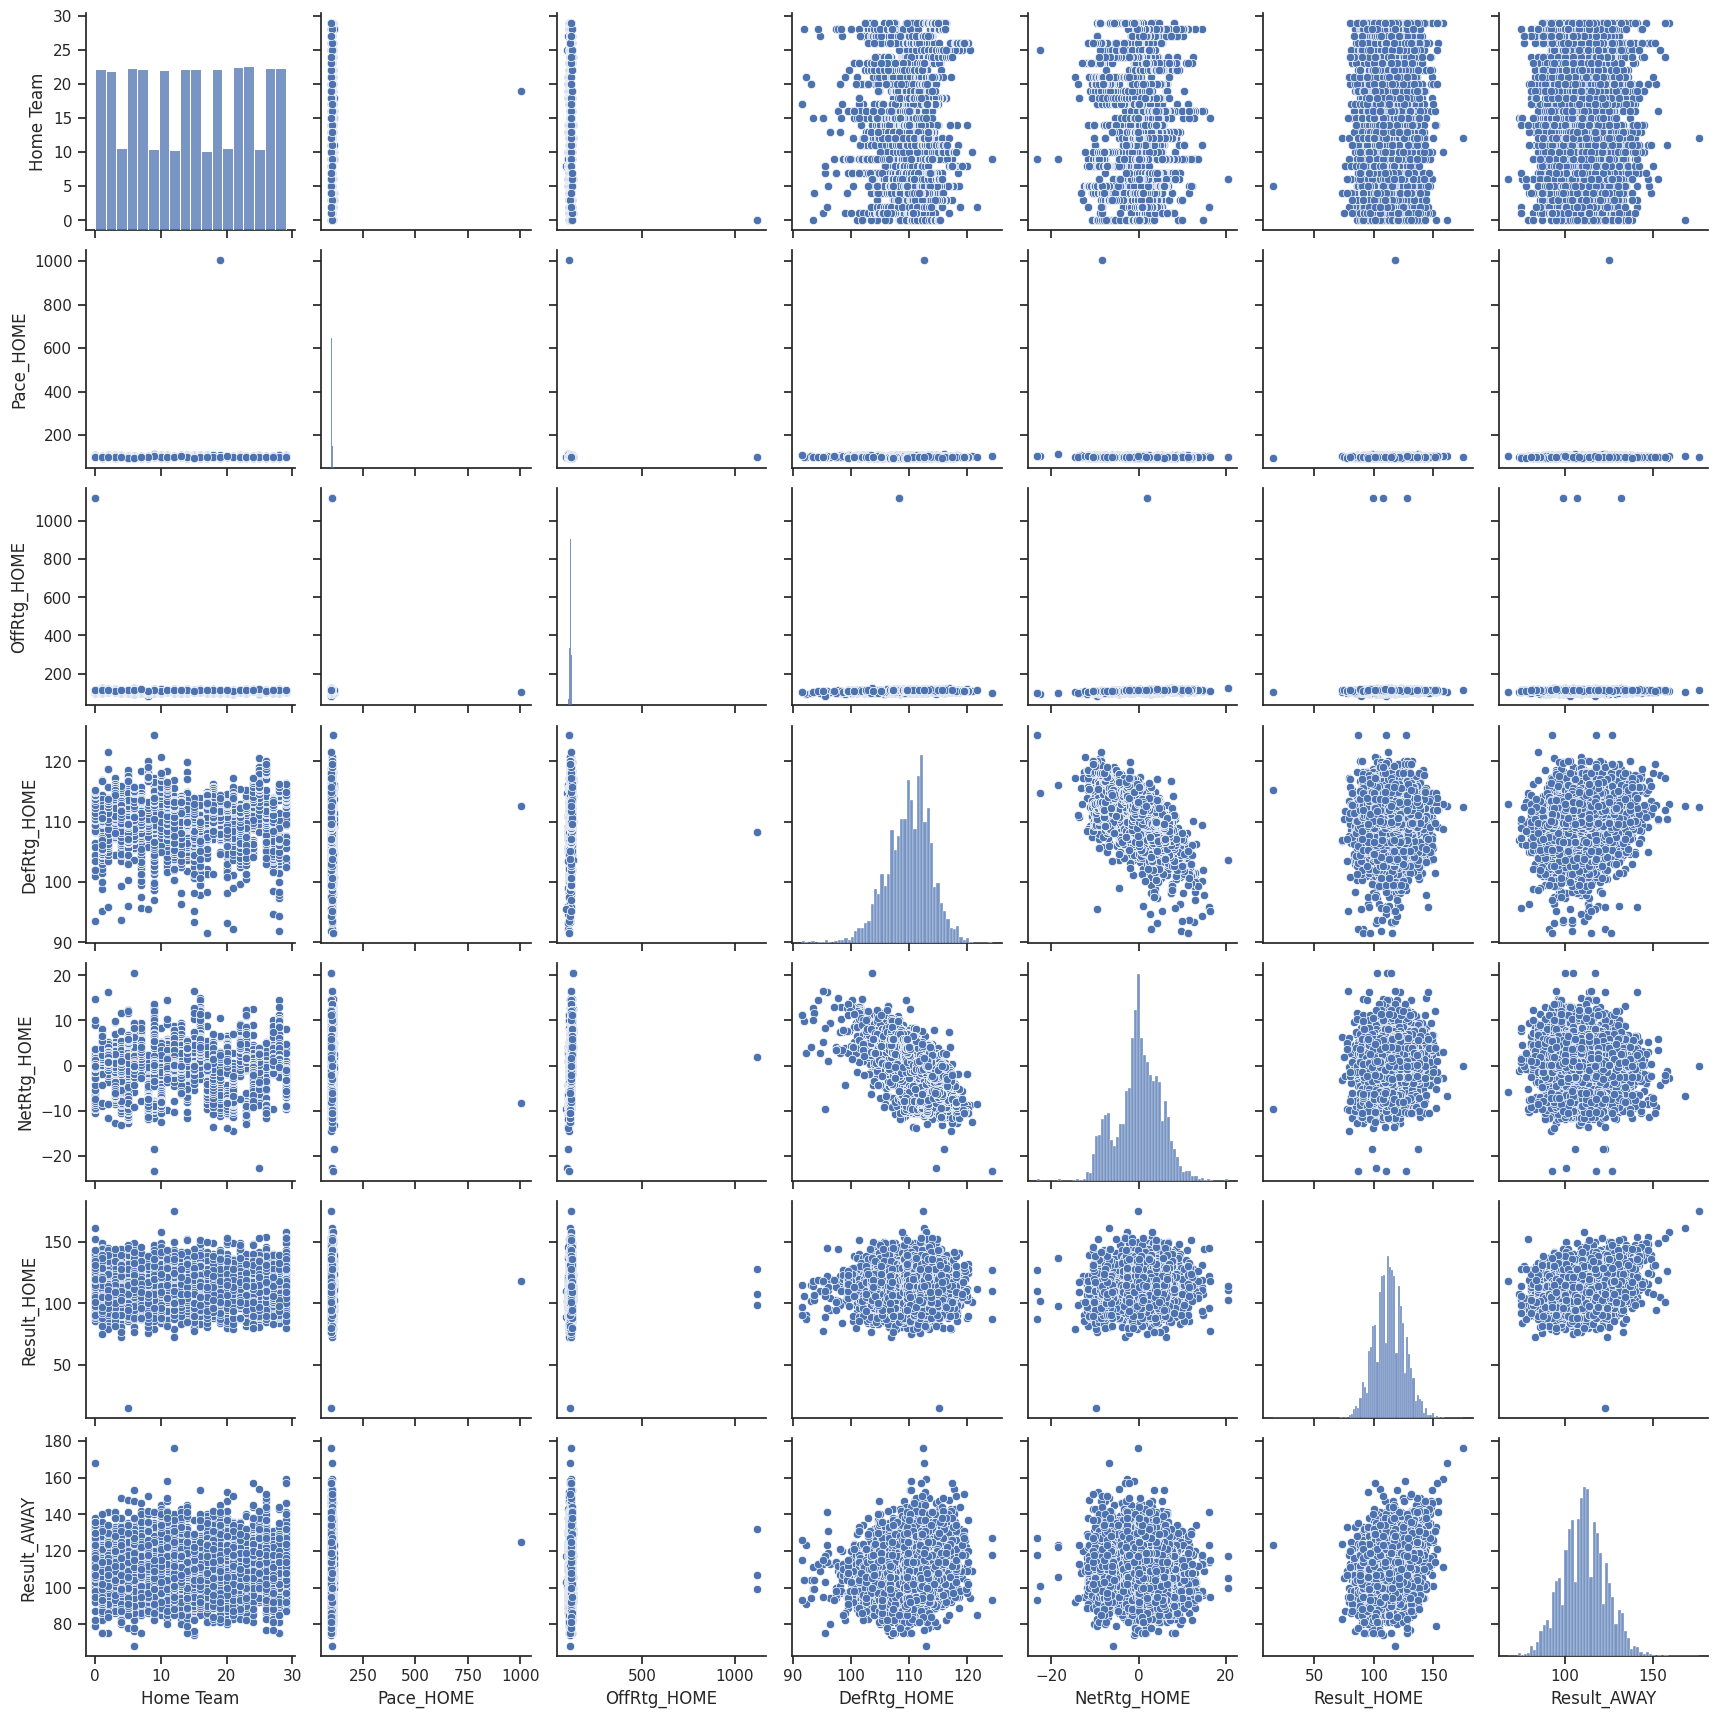

In [5]:
sns.set_theme(style="ticks")

sns.pairplot(df[['Home Team', 'Pace_HOME', 'OffRtg_HOME', 'DefRtg_HOME',
       'NetRtg_HOME', 'Result_HOME', 'Result_AWAY']])

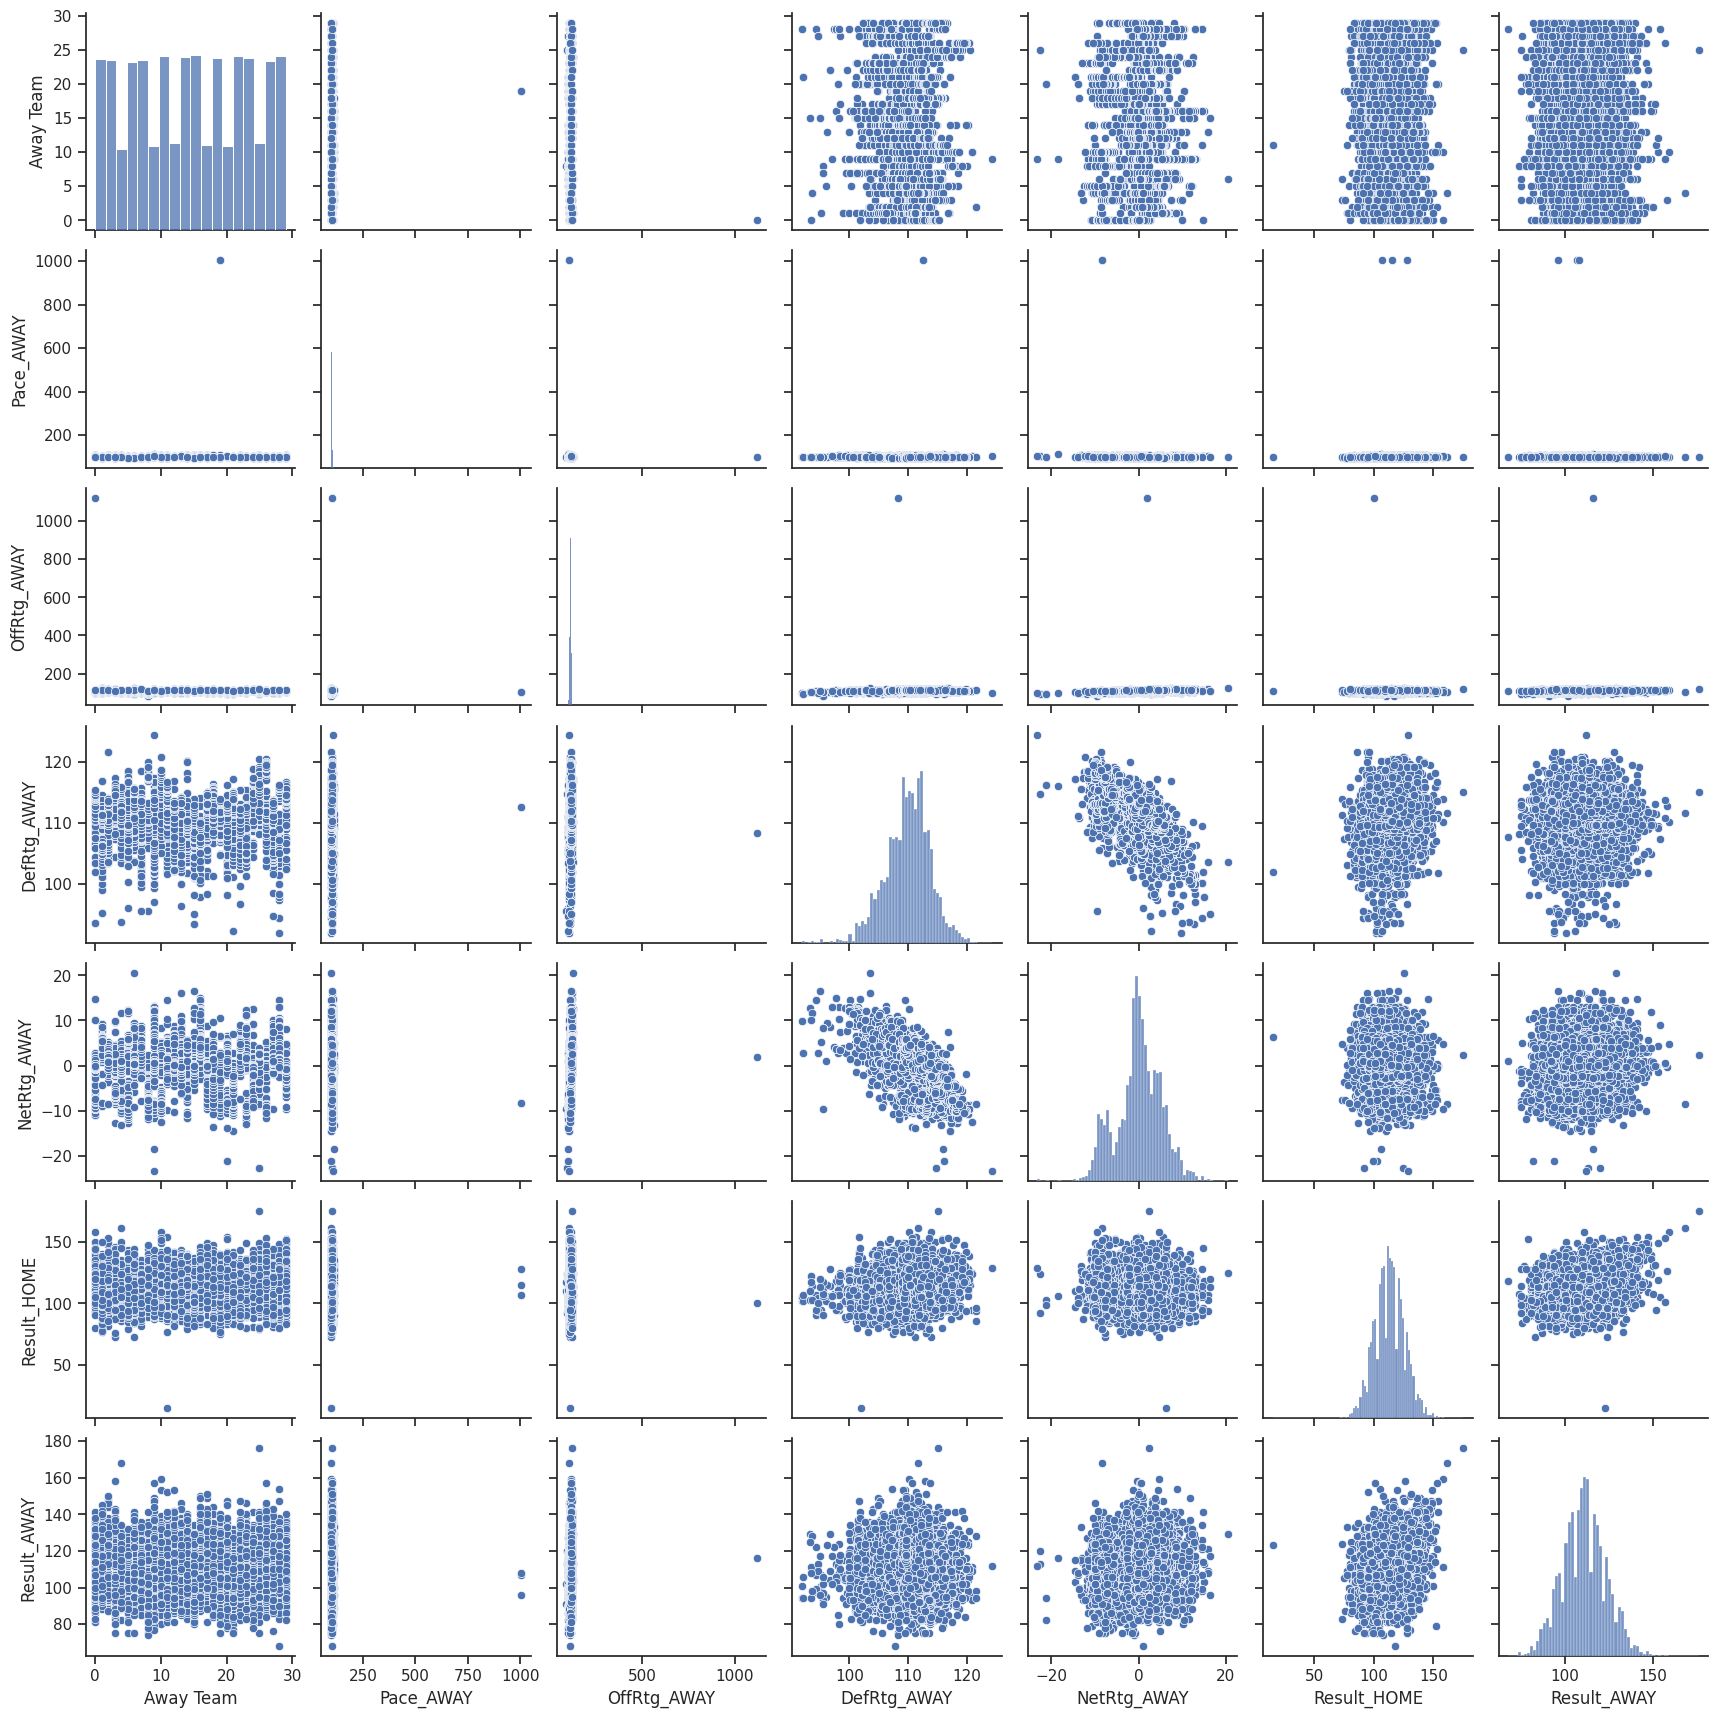

In [6]:
sns.set_theme(style="ticks")

sns.pairplot(df[['Away Team', 'Pace_AWAY', 'OffRtg_AWAY', 'DefRtg_AWAY', 'NetRtg_AWAY',
       'Result_HOME', 'Result_AWAY']])

<Axes: >

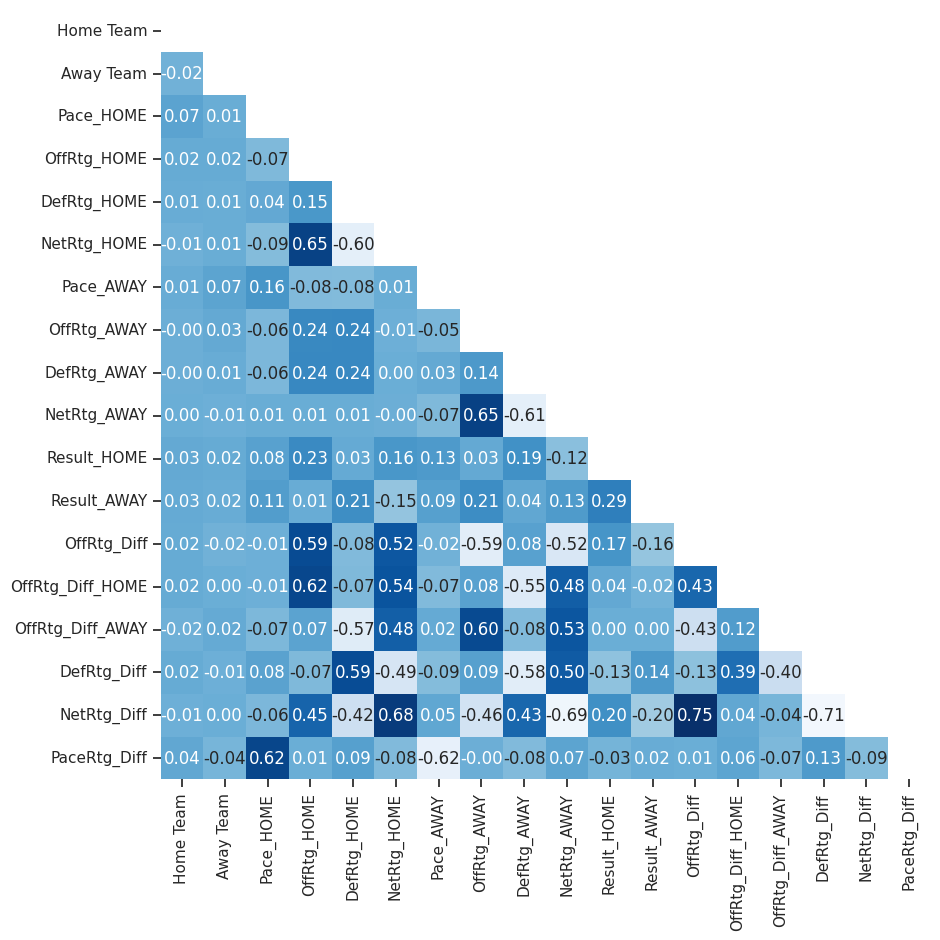

In [7]:
corr = df.corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 10)
sns.heatmap(corr, ax=ax, annot=True, mask=mask, fmt='.2f', cbar=False, square=True, cmap=plt.cm.Blues, center=0)

##Pincipal Component Analysis

In [8]:
x_pca = df.drop(['Home Team', 'Away Team', 'Result_HOME', 'Result_AWAY'], axis=1)
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
X_pca = scaler.fit_transform(x_pca)

In [9]:
x_pca.columns

Index(['Pace_HOME', 'OffRtg_HOME', 'DefRtg_HOME', 'NetRtg_HOME', 'Pace_AWAY',
       'OffRtg_AWAY', 'DefRtg_AWAY', 'NetRtg_AWAY', 'OffRtg_Diff',
       'OffRtg_Diff_HOME', 'OffRtg_Diff_AWAY', 'DefRtg_Diff', 'NetRtg_Diff',
       'PaceRtg_Diff'],
      dtype='object')

In [10]:
pca = PCA(n_components=None)
pca.fit(X_pca)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

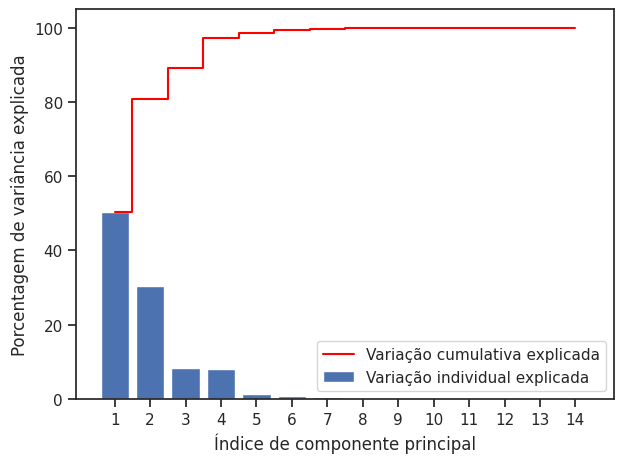

In [47]:
ticks = ['Pace_HOME', 'OffRtg_HOME', 'DefRtg_HOME', 'NetRtg_HOME', 'Pace_AWAY',
       'OffRtg_AWAY', 'DefRtg_AWAY', 'NetRtg_AWAY', 'OffRtg_Diff',
       'OffRtg_Diff_HOME', 'OffRtg_Diff_AWAY', 'DefRtg_Diff', 'NetRtg_Diff',
       'PaceRtg_Diff']
plt.bar(range(1, 15), exp_var, align='center',
        label='Variação individual explicada')

plt.step(range(1, 15), cum_exp_var, where='mid',
         label='Variação cumulativa explicada', color='red')

plt.ylabel('Porcentagem de variância explicada')
plt.xlabel('Índice de componente principal')
plt.xticks(ticks=range(1, 15))
plt.legend(loc='best')
plt.tight_layout()

plt.savefig("Barplot.png")

#Auxiliar func

In [48]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print("y1 MSE:%.4f" % mean_squared_error(test_labels['Result_HOME'], predictions[:,0]))
    print("y2 MSE:%.4f" % mean_squared_error(test_labels['Result_AWAY'], predictions[:,1]))
    print('Model Performance')
    print('Average Error: Home Result {:.4f} degrees and Away Result {:.4f} degrees.'.format(np.mean(errors)['Result_HOME'], np.mean(errors)['Result_AWAY']))
    print('Accuracy Home Result {:0.2f}% and Away Result {:0.2f}%.'.format(accuracy['Result_HOME'], accuracy['Result_AWAY']))

    return accuracy

#Model Training without PCA applied

In [49]:
x = df.drop(['Result_HOME', 'Result_AWAY'], axis=1)
y = df[['Result_HOME', 'Result_AWAY']]
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
X = scaler.fit_transform(x)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

###Ridge

In [50]:
params = { 'alpha': [1e-3, 1e-2, 1e-1, 1] }
grid = GridSearchCV(Ridge(), param_grid=params, cv=10, scoring='r2', return_train_score=True)
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1]},
             return_train_score=True, scoring='r2')

In [51]:
# Fazer previsões para os conjuntos de treinamento e teste
y_train_pred = grid.best_estimator_.predict(x_train)
y_test_pred = grid.best_estimator_.predict(x_test)

# Calcular as métricas de avaliação
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Imprimir as métricas
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

MSE:  305.1890630881743
MAE:  9.891974282535038
R2:  -0.9098834411887964


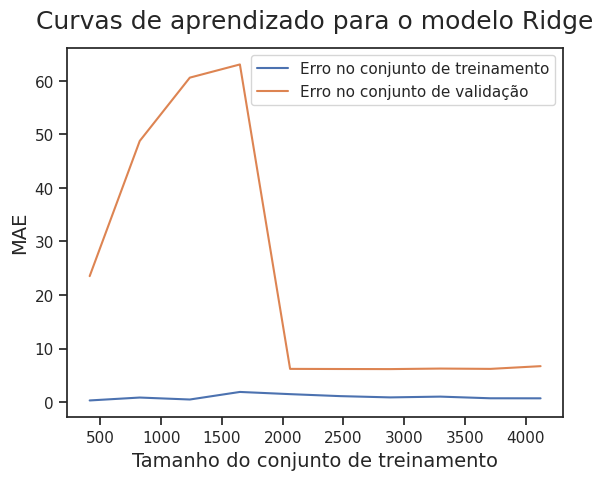

In [52]:
from sklearn.model_selection import learning_curve

# Função para plotar a curva de aprendizagem com as curvas de perda
def plot_learning_curve_with_loss(estimator, title, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')

    # Calcula as médias e desvios padrão das perdas de treino e teste
    train_losses = -np.mean(train_scores, axis=1)
    train_losses_std = np.std(train_scores, axis=1)
    test_losses = -np.mean(test_scores, axis=1)
    test_losses_std = np.std(test_scores, axis=1)

    # Plota a curva de aprendizagem com as curvas de perda
    plt.figure()

    plt.plot(train_sizes, train_losses_std, label = 'Erro no conjunto de treinamento')
    plt.plot(train_sizes, test_losses_std, label = 'Erro no conjunto de validação')

    plt.ylabel('MAE', fontsize = 14)
    plt.xlabel('Tamanho do conjunto de treinamento', fontsize = 14)
    title = 'Curvas de aprendizado para o modelo ' + str(estimator).split('(')[0]
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    return plt

# Utilizando o melhor estimador encontrado pelo grid search
best_estimator = grid.best_estimator_

# Plotando a curva de aprendizagem com as curvas de perda
plot_learning_curve_with_loss(best_estimator, "Curva de Aprendizagem Ridge (Perda)", x_train, y_train, cv=10)
plt.show()


###Random Forest

In [19]:
paramenters={'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramenters, n_iter = 3, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [20]:
best_random = rf_random.best_estimator_
best_random

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=200, random_state=42)

In [21]:
# Fazer previsões para os conjuntos de treinamento e teste
y_train_pred = best_random.predict(x_train)
y_test_pred = best_random.predict(x_test)

# Calcular as métricas de avaliação
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Imprimir as métricas
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

MSE:  146.8591829215676
MAE:  9.55671521928287
R2:  0.08118822234205503


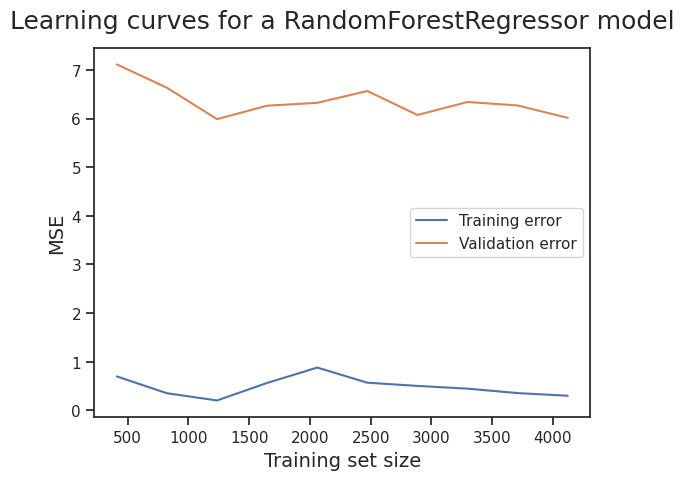

In [22]:
from sklearn.model_selection import learning_curve

# Função para plotar a curva de aprendizagem com as curvas de perda
def plot_learning_curve_with_loss(estimator, title, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')

    # Calcula as médias e desvios padrão das perdas de treino e teste
    train_losses = -np.mean(train_scores, axis=1)
    train_losses_std = np.std(train_scores, axis=1)
    test_losses = -np.mean(test_scores, axis=1)
    test_losses_std = np.std(test_scores, axis=1)

    # Plota a curva de aprendizagem com as curvas de perda
    plt.figure()

    plt.plot(train_sizes, train_losses_std, label = 'Training error')
    plt.plot(train_sizes, test_losses_std, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    return plt

# Utilizando o melhor estimador encontrado pelo grid search
best_estimator = best_random

# Plotando a curva de aprendizagem com as curvas de perda
plot_learning_curve_with_loss(best_estimator, "Curva de Aprendizagem Ridge (Perda)", x_train, y_train, cv=10)
plt.show()


## RN

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [24]:
model = Sequential(name='NBA')
model.add(Dense(90, input_dim = 16, activation='relu', name='Hidden-1'))
model.add(Dense(30, activation='relu', name='Hidden-2'))
model.add(Dense(2, activation='linear', name='Output'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
hist = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
115/115 [==============================] - 2s 6ms/step - loss: 10652.8652 - mae: 101.9113 - val_loss: 7260.5166 - val_mae: 83.1460
Epoch 2/100
115/115 [==============================] - 0s 4ms/step - loss: 3125.9646 - mae: 47.3456 - val_loss: 595.2875 - val_mae: 20.0053
Epoch 3/100
115/115 [==============================] - 0s 4ms/step - loss: 227.9629 - mae: 12.0126 - val_loss: 175.8400 - val_mae: 10.3414
Epoch 4/100
115/115 [==============================] - 0s 4ms/step - loss: 170.7222 - mae: 10.4116 - val_loss: 163.8334 - val_mae: 9.9665
Epoch 5/100
115/115 [==============================] - 0s 3ms/step - loss: 161.9538 - mae: 10.1283 - val_loss: 161.9471 - val_mae: 9.9132
Epoch 6/100
115/115 [==============================] - 0s 4ms/step - loss: 158.6120 - mae: 10.0164 - val_loss: 165.4669 - val_mae: 10.0382
Epoch 7/100
115/115 [==============================] - 0s 4ms/step - loss: 156.3641 - mae: 9.9396 - val_loss: 157.9624 - val_mae: 9.8046
Epoch 8/100
115/115 [=====

In [25]:
# Fazer previsões para os conjuntos de treinamento e teste
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calcular as métricas de avaliação
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Imprimir as métricas
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

36/36 [==============================] - 0s 1ms/step
MSE:  186.8192189307806
MAE:  9.779222042356693
R2:  -0.1687177274412478


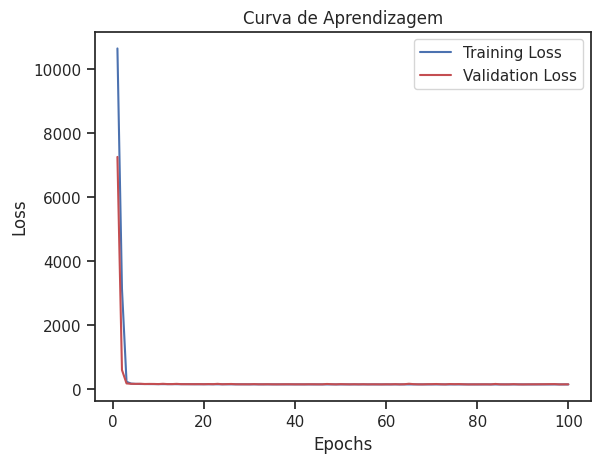

In [26]:
# Extrair as métricas de treinamento e validação do histórico
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotar a curva de aprendizagem
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Curva de Aprendizagem')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## LSTM

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM
from sklearn.preprocessing import StandardScaler


In [28]:
X_lstm = x.values #trocar por teu X
y_lstm = y.values #trocar por teu Y

scaler = StandardScaler()
X_lstm = scaler.fit_transform(X)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

timesteps = 1
input_dim = X_lstm.shape[1]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], timesteps, input_dim)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], timesteps, input_dim)

model = Sequential()
model.add(LSTM(units=128, input_shape=(timesteps, input_dim)))
model.add(Dense(units=2))
model.compile(loss='mse', optimizer='adam')

# model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)
history = model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

loss = model.evaluate(X_test_lstm, y_test_lstm, batch_size=32)

predictions = model.predict(X_test_lstm)


Epoch 1/100
144/144 [==============================] - 5s 15ms/step - loss: 12484.3545 - val_loss: 11898.2764
Epoch 2/100
144/144 [==============================] - 1s 8ms/step - loss: 10882.0420 - val_loss: 9752.9902
Epoch 3/100
144/144 [==============================] - 1s 6ms/step - loss: 8708.3760 - val_loss: 7680.8584
Epoch 4/100
144/144 [==============================] - 1s 6ms/step - loss: 6758.1250 - val_loss: 5895.1650
Epoch 5/100
144/144 [==============================] - 1s 6ms/step - loss: 5105.9907 - val_loss: 4403.9766
Epoch 6/100
144/144 [==============================] - 1s 5ms/step - loss: 3746.2878 - val_loss: 3192.9241
Epoch 7/100
144/144 [==============================] - 1s 6ms/step - loss: 2656.2820 - val_loss: 2232.9668
Epoch 8/100
144/144 [==============================] - 1s 5ms/step - loss: 1811.5109 - val_loss: 1494.6338
Epoch 9/100
144/144 [==============================] - 1s 5ms/step - loss: 1182.8301 - val_loss: 955.4577
Epoch 10/100
144/144 [============

In [29]:
# Fazer previsões para os conjuntos de treinamento e teste
y_train_pred = model.predict(X_train_lstm)
y_test_pred = model.predict(X_test_lstm)

# Calcular as métricas de avaliação
mse = mean_squared_error(y_test_lstm, y_test_pred)
mae = mean_absolute_error(y_test_lstm, y_test_pred)
r2 = r2_score(y_test_lstm, y_test_pred)

# Imprimir as métricas
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

36/36 [==============================] - 0s 2ms/step
MSE:  140.07259970387173
MAE:  9.43580205694335
R2:  0.08584905350775851


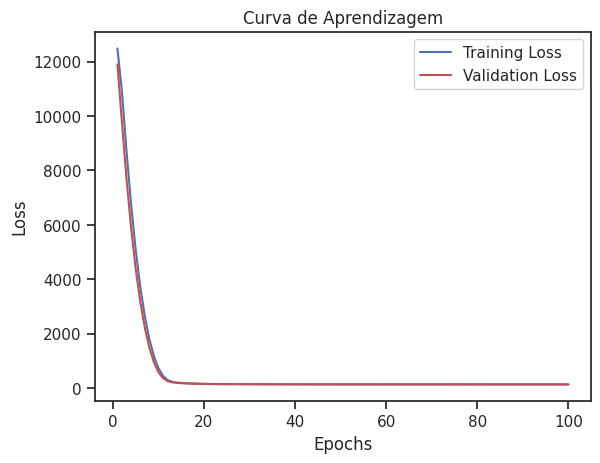

In [30]:
# Extrair as métricas de treinamento e validação do histórico
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotar a curva de aprendizagem
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Curva de Aprendizagem')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Model training with PCA

In [56]:
x = df[['Home Team', 'Away Team', 'Pace_HOME', 'OffRtg_HOME', 'DefRtg_HOME', 'NetRtg_HOME']]
y = df[['Result_HOME', 'Result_AWAY']]
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
X = scaler.fit_transform(x)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=20,random_state=0)

###Ridge

In [57]:
params = { 'alpha': [1e-3, 1e-2, 1e-1, 1] }
grid = GridSearchCV(Ridge(), param_grid=params, cv=10, scoring='r2')
grid.fit(x_train, y_train)
print(f'R-squared: {grid.best_score_}.')

R-squared: 0.04441881778551365.


In [58]:
# Fazer previsões para os conjuntos de treinamento e teste
y_train_pred = grid.best_estimator_.predict(x_train)
y_test_pred = grid.best_estimator_.predict(x_test)

# Calcular as métricas de avaliação
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Imprimir as métricas
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

MSE:  121.18531830233385
MAE:  8.553296154255492
R2:  0.08532787111284074


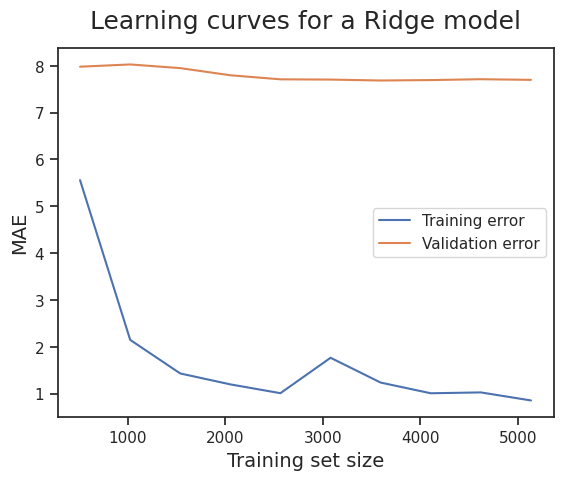

In [59]:
from sklearn.model_selection import learning_curve

# Função para plotar a curva de aprendizagem com as curvas de perda
def plot_learning_curve_with_loss(estimator, title, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')

    # Calcula as médias e desvios padrão das perdas de treino e teste
    train_losses = -np.mean(train_scores, axis=1)
    train_losses_std = np.std(train_scores, axis=1)
    test_losses = -np.mean(test_scores, axis=1)
    test_losses_std = np.std(test_scores, axis=1)

    # Plota a curva de aprendizagem com as curvas de perda
    plt.figure()

    plt.plot(train_sizes, train_losses_std, label = 'Training error')
    plt.plot(train_sizes, test_losses_std, label = 'Validation error')

    plt.ylabel('MAE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    return plt

# Utilizando o melhor estimador encontrado pelo grid search
best_estimator = grid.best_estimator_

# Plotando a curva de aprendizagem com as curvas de perda
plot_learning_curve_with_loss(best_estimator, "Curva de Aprendizagem Ridge (Perda)", x_train, y_train, cv=10)
plt.show()


###Random Forest

In [60]:
paramenters={'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramenters, n_iter = 3, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


KeyboardInterrupt: ignored

In [38]:
best_random = rf_random.best_estimator_
best_random

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=200, random_state=42)

In [39]:
# Fazer previsões para os conjuntos de treinamento e teste
y_train_pred = best_random.predict(x_train)
y_test_pred = best_random.predict(x_test)

# Calcular as métricas de avaliação
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Imprimir as métricas
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

MSE:  138.61896939948147
MAE:  9.422060047631449
R2:  -0.03617437105237875


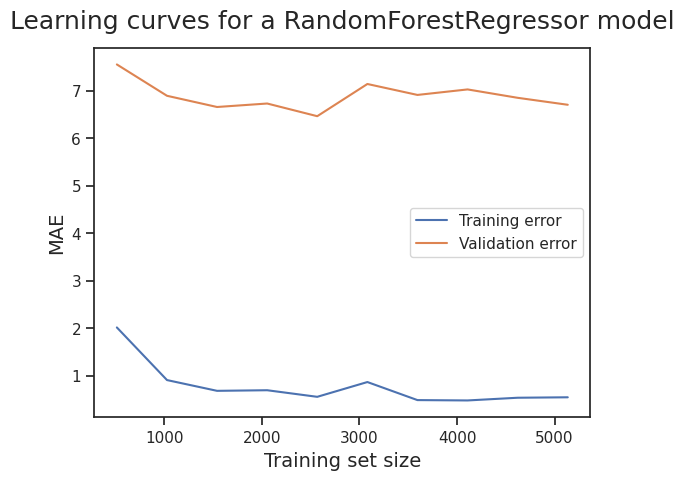

In [61]:
from sklearn.model_selection import learning_curve

# Função para plotar a curva de aprendizagem com as curvas de perda
def plot_learning_curve_with_loss(estimator, title, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')

    # Calcula as médias e desvios padrão das perdas de treino e teste
    train_losses = -np.mean(train_scores, axis=1)
    train_losses_std = np.std(train_scores, axis=1)
    test_losses = -np.mean(test_scores, axis=1)
    test_losses_std = np.std(test_scores, axis=1)

    # Plota a curva de aprendizagem com as curvas de perda
    plt.figure()

    plt.plot(train_sizes, train_losses_std, label = 'Training error')
    plt.plot(train_sizes, test_losses_std, label = 'Validation error')

    plt.ylabel('MAE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    return plt

# Utilizando o melhor estimador encontrado pelo grid search
best_estimator = best_random

# Plotando a curva de aprendizagem com as curvas de perda
plot_learning_curve_with_loss(best_estimator, "Curva de Aprendizagem Ridge (Perda)", x_train, y_train, cv=10)
plt.show()


## RN

In [41]:
model = Sequential(name='NBA')
model.add(Dense(90, input_dim = 6, activation='relu', name='Hidden-1'))
model.add(Dense(30, activation='relu', name='Hidden-2'))
model.add(Dense(2, activation='linear', name='Output'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
hist = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
143/143 [==============================] - 1s 4ms/step - loss: 11256.5645 - mae: 105.1539 - val_loss: 8451.6172 - val_mae: 90.8839
Epoch 2/100
143/143 [==============================] - 0s 3ms/step - loss: 4004.6379 - mae: 56.7908 - val_loss: 734.1099 - val_mae: 22.2408
Epoch 3/100
143/143 [==============================] - 0s 2ms/step - loss: 361.7377 - mae: 15.1565 - val_loss: 259.9282 - val_mae: 12.7942
Epoch 4/100
143/143 [==============================] - 0s 2ms/step - loss: 228.3256 - mae: 12.0240 - val_loss: 201.2574 - val_mae: 11.1112
Epoch 5/100
143/143 [==============================] - 0s 3ms/step - loss: 185.3385 - mae: 10.8389 - val_loss: 175.9769 - val_mae: 10.3474
Epoch 6/100
143/143 [==============================] - 0s 3ms/step - loss: 169.1974 - mae: 10.3402 - val_loss: 170.9625 - val_mae: 10.2121
Epoch 7/100
143/143 [==============================] - 0s 3ms/step - loss: 165.5127 - mae: 10.2159 - val_loss: 171.0277 - val_mae: 10.2067
Epoch 8/100
143/143 [=

In [42]:
# Fazer previsões para os conjuntos de treinamento e teste
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calcular as métricas de avaliação
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Imprimir as métricas
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

1/1 [==============================] - 0s 22ms/step
MSE:  125.99852331934818
MAE:  8.959393119812011
R2:  0.050447238104908865


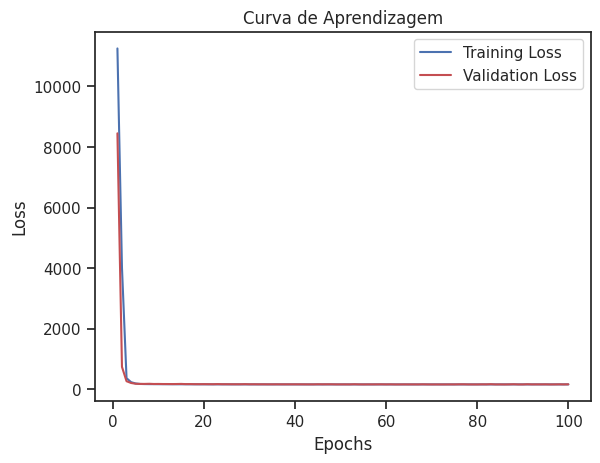

In [43]:
# Extrair as métricas de treinamento e validação do histórico
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotar a curva de aprendizagem
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Curva de Aprendizagem')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## LSTM

In [44]:
X_lstm = x.values #trocar por teu X
y_lstm = y.values #trocar por teu Y

scaler = StandardScaler()
X_lstm = scaler.fit_transform(X)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

timesteps = 1
input_dim = X_lstm.shape[1]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], timesteps, input_dim)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], timesteps, input_dim)

model = Sequential()
model.add(LSTM(units=128, input_shape=(timesteps, input_dim)))
model.add(Dense(units=2))
model.compile(loss='mse', optimizer='adam')

# model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)
history = model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

loss = model.evaluate(X_test_lstm, y_test_lstm, batch_size=32)

predictions = model.predict(X_test_lstm)


Epoch 1/100
144/144 [==============================] - 5s 12ms/step - loss: 12558.1084 - val_loss: 12143.6230
Epoch 2/100
144/144 [==============================] - 1s 6ms/step - loss: 11266.8457 - val_loss: 10164.7744
Epoch 3/100
144/144 [==============================] - 1s 6ms/step - loss: 8990.5166 - val_loss: 7809.6494
Epoch 4/100
144/144 [==============================] - 1s 8ms/step - loss: 6722.5732 - val_loss: 5688.2568
Epoch 5/100
144/144 [==============================] - 1s 9ms/step - loss: 4774.8887 - val_loss: 3922.4268
Epoch 6/100
144/144 [==============================] - 1s 8ms/step - loss: 3194.5764 - val_loss: 2523.2590
Epoch 7/100
144/144 [==============================] - 1s 9ms/step - loss: 1980.6094 - val_loss: 1487.8770
Epoch 8/100
144/144 [==============================] - 1s 6ms/step - loss: 1122.9189 - val_loss: 802.4427
Epoch 9/100
144/144 [==============================] - 1s 6ms/step - loss: 594.8151 - val_loss: 424.6160
Epoch 10/100
144/144 [=============

In [45]:
# Fazer previsões para os conjuntos de treinamento e teste
y_train_pred = model.predict(X_train_lstm)
y_test_pred = model.predict(X_test_lstm)

# Calcular as métricas de avaliação
mse = mean_squared_error(y_test_lstm, y_test_pred)
mae = mean_absolute_error(y_test_lstm, y_test_pred)
r2 = r2_score(y_test_lstm, y_test_pred)

# Imprimir as métricas
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

36/36 [==============================] - 0s 2ms/step
MSE:  146.62637161413244
MAE:  9.611032432702615
R2:  0.04285453810012679


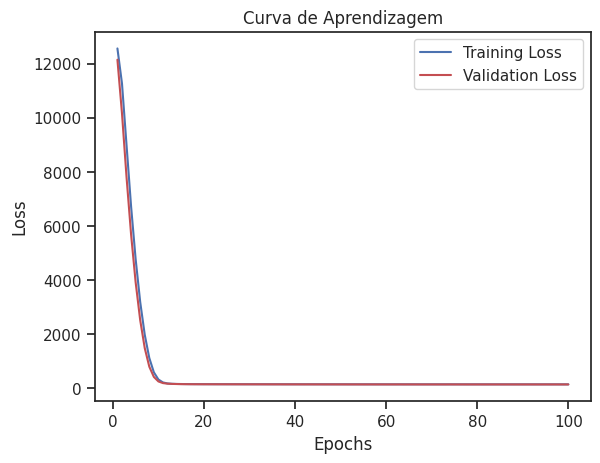

In [46]:
# Extrair as métricas de treinamento e validação do histórico
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotar a curva de aprendizagem
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Curva de Aprendizagem')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()